In [15]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [16]:
df = pd.read_csv('C:/Users/bacho/Desktop/Modulo 4/proyecto/Heart.csv')
df["MEDV"] = df.target
df= df.drop("target",1)
X = df.drop("MEDV",1)   #Características
y = df["MEDV"]          #Target
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,MEDV
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


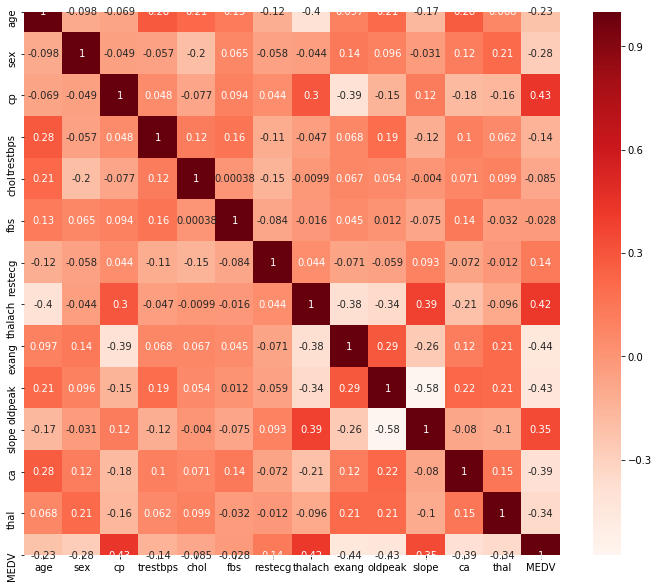

In [17]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
#Correlación respecto a la variable de salida o target
cor_target = abs(cor["MEDV"])

#Selección de características altamente correlacionadas
relevant_features = cor_target[cor_target>0.4]
relevant_features

cp         0.433798
thalach    0.421741
exang      0.436757
oldpeak    0.430696
MEDV       1.000000
Name: MEDV, dtype: float64

In [19]:
print(df[["cp","thalach","oldpeak","exang"]].corr())


               cp   thalach   oldpeak     exang
cp       1.000000  0.295762 -0.149230 -0.394280
thalach  0.295762  1.000000 -0.344187 -0.378812
oldpeak -0.149230 -0.344187  1.000000  0.288223
exang   -0.394280 -0.378812  0.288223  1.000000


In [20]:
#Agregar una columna constante de unos, obligatorio para el modelo sm.OLS
X_1 = sm.add_constant(X)

#Ajuste del modelo sm.OLS
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)

C:\Users\bacho\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


age         7.455035e-01
fbs         6.232919e-01
chol        4.063410e-01
restecg     2.092376e-01
trestbps    1.096252e-01
slope       6.064276e-02
oldpeak     1.140514e-02
thalach     8.265890e-03
exang       5.095587e-03
const       4.750503e-03
thal        9.984014e-04
sex         3.974171e-05
ca          5.497267e-06
cp          9.697534e-07
dtype: float64

In [21]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['sex', 'cp', 'thalach', 'exang', 'oldpeak', 'ca', 'thal']


In [22]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
[False  True  True False False False False False  True  True  True  True
  True]
[6 1 1 5 7 3 2 4 1 1 1 1 1]


In [23]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 11
Desempeño con 11 características: 0.441531


In [24]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['sex', 'cp', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
       'ca', 'thal'],
      dtype='object')


In [25]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

Número óptimo de características:12
Desempeño mediante la regularización Lasso: 0.516022


C:\Users\bacho\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
